In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def plot_forecasts( title, model_names, model_forecasts, truth ):
    plt.style.use('ggplot')
    plt.figure(figsize=(24,12))
    
    plt.plot( truth['date'], truth['cases'], label='Ground Truth')
    
    for model_name, model_forecast in zip( model_names, model_forecasts ):
        plt.plot( model_forecast['date'], model_forecast['forecast'], label=model_name)
        
    plt.xlabel("Date", fontsize=30)
    plt.ylabel("Cases", fontsize=30)
    _ = plt.xticks(rotation='vertical') # _ = is used to suppress the console output
    plt.legend(fontsize=20)
    plt.title(title, fontsize=30)
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)
    # plt.legend(fontsize=30)
    # plt.ylim(0, 3000)    

def plot_errors( title, y_label, model_names, model_errors ):
    plt.style.use('ggplot')
    plt.figure(figsize=(24,12))
    
    plt.bar( model_names, model_errors )        
    plt.xlabel("Model", fontsize=30)
    plt.ylabel(y_label, fontsize=30)
    _ = plt.xticks(rotation='vertical') # _ = is used to suppress the console output
#     plt.legend(fontsize=20)
    plt.title(title, fontsize=30)
    plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)
    # plt.legend(fontsize=30)
    # plt.ylim(0, 3000)    

def get_model_data( model_path ):
    model_data = None
    
    for file_name in os.listdir( model_path ):
        if file_name.endswith('.csv'):
            # We represent location contents as strings, to avoid, for example, the truncation of leading zeros.
            file_data = pd.read_csv( model_path + os.path.sep + file_name, dtype={'location': 'string'} ) # Note: the "NA" quantile values are treated by Pandas as NaNs.
#             print( 'Read: ' + file_name )
            if model_data is None:
                model_data = file_data
            else:
                model_data = pd.concat( [ model_data, file_data ] )
    
    return model_data

# Note: this method is only appropriate for converting incident data (e.g., truth-Incident Cases.csv); it is not appropriate for converting
# cumulative data (e.g., truth-Cumulative Cases.csv).
def convert_days_to_weeks( data ):
    # Note that the first week is missing three days, so we fill these in with blank values.
    dates = [None, None, None]
    dates.extend( list( data['date'] ) )
    daily_cases = [0, 0, 0]
    daily_cases.extend( list( data['value'] ) )

    weeks = []
    weekly_cases = []

    # The first week is missing three days.
    for i in range( math.floor( len(dates) / 7 ) ):
        weeks.append( dates[i * 7 + 6] )
        weekly_cases.append( sum( daily_cases[ i * 7 : ( i + 1 ) * 7 ] ) )

    return pd.DataFrame( { 'date': weeks, 'cases': weekly_cases } )
    
def constant_forecast( truth_data, forecast_horizon ):
    weekly_cases = truth_data['cases']
    
    constant_forecast_cases = [ 0 ] * forecast_horizon
    constant_forecast_cases.extend( weekly_cases[: len(weekly_cases) - forecast_horizon] )
    
    return pd.DataFrame( { 'date': truth_data['date'], 'forecast': constant_forecast_cases, 'truth' : truth_data['cases'] } )

def linear_forecast( truth_data, forecast_horizon ):
    weekly_cases = truth_data['cases']
    
    # Approach 1:
#     linear_forecast_cases = [ 0 ] * ( forecast_horizon + 1 )
#     for i in range( forecast_horizon + 1, len(weekly_cases) ):
#         linear_forecast = weekly_cases[i - forecast_horizon] + ( weekly_cases[i - forecast_horizon] - weekly_cases[i - forecast_horizon - 1] ) * forecast_horizon
#         linear_forecast_cases.append( linear_forecast )

    # Approach 2:
    linear_forecast_cases = [ 0 ] * ( forecast_horizon * 2 )
    for i in range( forecast_horizon * 2, len(weekly_cases) ):
        linear_forecast = weekly_cases[i - forecast_horizon] + ( weekly_cases[i - forecast_horizon] - weekly_cases[i - forecast_horizon * 2] )
        linear_forecast_cases.append( linear_forecast )

#     if visualize:
#         location_data = all_data.loc[ all_data['location'] == location, [ 'location_name' ] ]
#         location_name = location_data.iloc[0]['location_name']
#         plot_forecasts( location_name + ' (' + location + ')', weeks, weekly_cases, constant_forecast_cases, linear_forecast_cases )
    
    return pd.DataFrame( { 'date': truth_data['date'], 'forecast': linear_forecast_cases, 'truth' : truth_data['cases'] } )

def model_forecast( truth_data, model_data ):
    combined_data = pd.merge( model_data.rename( columns={ 'target_end_date' : 'date' } ), truth_data, on='date', how='inner' )
    combined_data = combined_data.sort_values( by=['date'] )

    # print( model_data.dtypes )
    # print( truth_data.dtypes )

#     print( model_data )
#     print( truth_data )
#     print( combined_data )
    return pd.DataFrame( { 'date': combined_data['date'], 'forecast': combined_data['value'], 'truth' : combined_data['cases'], 'quantile' : combined_data['quantile'] } )

In [2]:
# The 'location' column contains both strings and integers; we represent its contents as strings.
all_truth_data = pd.read_csv( '../../covid19-forecast-hub/data-truth/truth-Incident Deaths.csv', dtype={'location': 'string'} )
locations = set( all_truth_data['location'] )
locations = list(locations)
locations.sort()

forecast_horizon = 4
target = str( forecast_horizon ) + ' wk ahead inc death'
# location = '01001'

required_quantiles = [ 0.010, 0.025, 0.050, 0.100, 0.150, 0.200, 0.250, 0.300, 0.350, 0.400, 0.450, 0.500, 0.550, 0.600, 0.650, 0.700, 0.750, 0.800, 0.850, 0.900, 0.950, 0.975, 0.990 ]
if target.endswith( 'wk ahead inc case' ):
    required_quantiles = [ 0.025, 0.100, 0.250, 0.500, 0.750, 0.900, 0.975 ]

model_names = []

for model_name in os.listdir( '../../covid19-forecast-hub/data-processed' ):
    if os.path.isdir( '../../covid19-forecast-hub/data-processed' + os.path.sep + model_name ):
        model_names.append( model_name )

model_names.append( 'Constant' )
model_names.append( 'Linear' )

# model_names.remove( 'DDS-NBDS' ) # This model had a very large forecasting error, at least, for the US.

In [3]:
# Here, we load the data, and attempt to clean it, when data quality issues are found.

# model_names = [ 'COVIDhub-ensemble', 'CMU-TimeSeries', 'Covid19Sim-Simulator', 'CU-select', 'GT-DeepCOVID', 'COVIDhub-baseline', 'Constant', 'Linear' ]
valid_model_names = []
model_forecasts = []
p_valid_model_names = []
p_model_forecasts = []

for model_name in model_names:
    print( 'Loading data for model: ' + model_name )
    
    forecasts_for_model = None
    p_forecasts_for_model = None
    
    if model_name != 'Constant' and model_name != 'Linear':
        all_model_data = get_model_data( '../../covid19-forecast-hub/data-processed' + os.path.sep + model_name )
        if all_model_data is None:
            print( 'Warning: no data available for model ' + model_name )
            continue
    
    for location in locations:
        if location == 'US' or len(location) != 2:
#         if location != 'US':
            continue
        
        truth_data = all_truth_data.loc[ all_truth_data['location'] == location ]
        location_name = truth_data.iloc[0]['location_name']
        truth_data = convert_days_to_weeks( truth_data )

        if model_name == 'Constant':
            forecast = constant_forecast( truth_data, forecast_horizon )
            p_forecast = pd.DataFrame( { 'date': [], 'forecast': [], 'truth' : [], 'quantile' : [] } )
        elif model_name == 'Linear':
            forecast = linear_forecast( truth_data, forecast_horizon )
            p_forecast = pd.DataFrame( { 'date': [], 'forecast': [], 'truth' : [], 'quantile' : [] } )
        else:
            model_data = all_model_data.loc[ ( ( all_model_data['target'] == target ) & ( all_model_data['location'] == location ) & ( all_model_data['type'] == 'point' ) ) ]
            forecast = model_forecast( truth_data, model_data )
            model_data = all_model_data.loc[ ( ( all_model_data['target'] == target ) & ( all_model_data['location'] == location ) & ( all_model_data['type'] == 'quantile' ) ) ]
            p_forecast = model_forecast( truth_data, model_data )
        
        unique_dates = set( forecast['date'] )
        unique_dates = list( unique_dates )
        unique_dates.sort()
        duplicate_entries_found = False
        invalid_forecasts_found = False
        for unique_date in unique_dates:
            entries_for_date = forecast.loc[ forecast['date'] == unique_date ]
            errors_found_for_date = False
            
            if len( entries_for_date ) > 1:
                duplicate_entries_found = True
                errors_found_for_date = True
                
            for index, row in entries_for_date.iterrows():
                if math.isnan( row['forecast'] ):
                    invalid_forecasts_found = True
                    errors_found_for_date = True
                    
            if errors_found_for_date:
                forecast = forecast.loc[ forecast['date'] != unique_date ]
        
        if duplicate_entries_found:
            print( 'Warning: duplicate point entries found for model ' + model_name + ', location ' + location_name )
        
        if invalid_forecasts_found:
            print( 'Warning: non-numeric point forecast values found for model ' + model_name + ', location ' + location_name )
        
        unique_dates = set( p_forecast['date'] )
        unique_dates = list( unique_dates )
        unique_dates.sort()
        duplicate_quantiles_found = False
        quantiles_missing = False
        invalid_forecasts_found = False
        for unique_date in unique_dates:
            entries_for_date = p_forecast.loc[ p_forecast['date'] == unique_date ]
            unique_quantiles_for_date = set( entries_for_date['quantile'] )
            errors_found_for_date = False
            
            if len( unique_quantiles_for_date ) != len( entries_for_date ):
                duplicate_quantiles_found = True
                errors_found_for_date = True

            for quantile in required_quantiles:
                if quantile not in unique_quantiles_for_date:
                    quantiles_missing = True
                    errors_found_for_date = True

            for index, row in entries_for_date.iterrows():
                if math.isnan( row['forecast'] ):
                    invalid_forecasts_found = True
                    errors_found_for_date = True
                    
            if errors_found_for_date:
                p_forecast = p_forecast.loc[ p_forecast['date'] != unique_date ]
        
        if duplicate_quantiles_found:
            print( 'Warning: duplicate quantile entries found for model ' + model_name + ', location ' + location_name )
            
        if quantiles_missing:
            print( 'Warning: missing quantile entries for model ' + model_name + ', location ' + location_name )
        
        if invalid_forecasts_found:
            print( 'Warning: non-numeric quantile forecast values found for model ' + model_name + ', location ' + location_name )
        
        forecast['location'] = [ location ] * len( forecast )
        if forecasts_for_model is None:
            forecasts_for_model = forecast
        else:
            forecasts_for_model = pd.concat( [ forecasts_for_model, forecast ] )
        
        p_forecast['location'] = [ location ] * len( p_forecast )
        if p_forecasts_for_model is None:
            p_forecasts_for_model = p_forecast
        else:
            p_forecasts_for_model = pd.concat( [ p_forecasts_for_model, p_forecast ] )
            
    if len( forecasts_for_model ) > 0:
        valid_model_names.append( model_name )
        model_forecasts.append( forecasts_for_model )
    else:
        print( 'Warning: no point data available for model ' + model_name )
        
    if len( p_forecasts_for_model ) > 0:
        p_valid_model_names.append( model_name )
        p_model_forecasts.append( p_forecasts_for_model )
    else:
        print( 'Warning: no quantile data available for model ' + model_name )

Loading data for model: STH-3PU
Loading data for model: Caltech-CS156
Loading data for model: Imperial-ensemble2
Loading data for model: Yu_Group-CLEP
Loading data for model: UChicago-CovidIL
Loading data for model: KITmetricslab-select_ensemble
Loading data for model: GT-DeepCOVID
Loading data for model: MUNI-ARIMA
Loading data for model: FDANIHASU-Sweight
Loading data for model: FAIR-NRAR
Loading data for model: UA-EpiCovDA
Loading data for model: MITCovAlliance-SIR
Loading data for model: JHU_CSSE-DECOM
Loading data for model: CU-scenario_high
Loading data for model: WalmartLabsML-LogForecasting
Loading data for model: UVA-Ensemble
Loading data for model: QJHong-Encounter
Loading data for model: RPI_UW-Mob_Collision
Loading data for model: SigSci-TS
Loading data for model: PandemicCentral-COVIDForest
Loading data for model: UCLA-SuEIR
Loading data for model: UChicago-CovidIL_60
Loading data for model: CDDEP-SEIR_MCMC
Loading data for model: OliverWyman-Navigator
Loading data for mod

In [4]:
# Because data loading raw data can take a long time, we saved the preprocessed data in a *.pickle file, so that it can be quickly reloaded (as is done in the cell below).

import pickle

with open( target + ' forecasts.pkl', 'wb') as output:
    pickle.dump( valid_model_names, output, pickle.HIGHEST_PROTOCOL )
    pickle.dump( model_forecasts, output, pickle.HIGHEST_PROTOCOL )
    pickle.dump( p_valid_model_names, output, pickle.HIGHEST_PROTOCOL )
    pickle.dump( p_model_forecasts, output, pickle.HIGHEST_PROTOCOL )

In [5]:
import pickle

with open( target + ' forecasts.pkl', 'rb') as input:
    valid_model_names = pickle.load(input)
    model_forecasts = pickle.load(input)
    p_valid_model_names = pickle.load(input)
    p_model_forecasts = pickle.load(input)

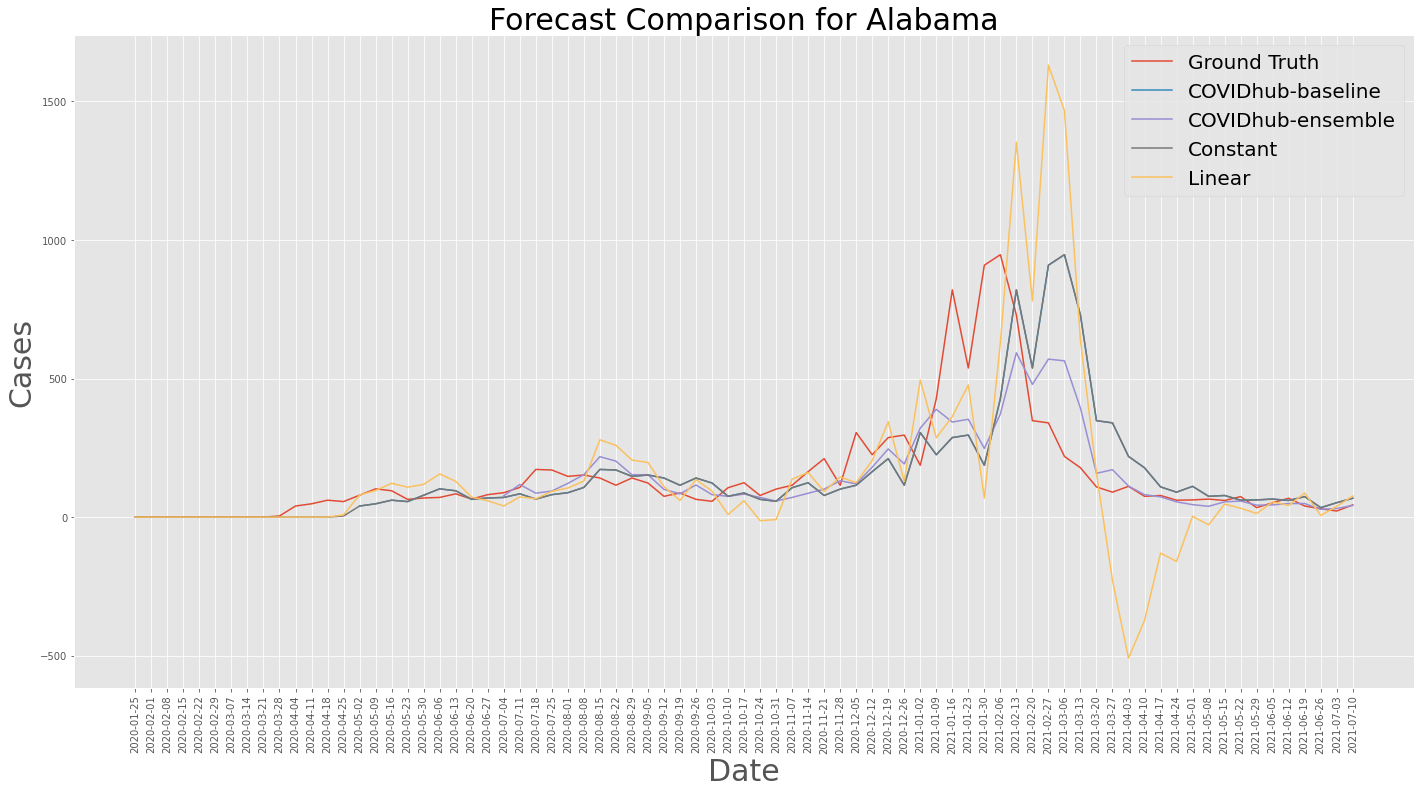

In [6]:
# Here, we plot forecasts made by several models for an example location (Alabama).

model_names_of_interest = [ 'COVIDhub-baseline', 'Constant', 'Linear', 'COVIDhub-ensemble' ]
location_to_plot = '01'

truth_data_to_plot = all_truth_data.loc[ all_truth_data['location'] == location_to_plot ]
location_name_to_plot = truth_data_to_plot.iloc[0]['location_name']
truth_data_to_plot = convert_days_to_weeks( truth_data_to_plot )

model_names_to_plot = []
model_forecasts_to_plot = []

for model_name, forecast in zip( valid_model_names, model_forecasts ):
    if model_name in model_names_of_interest:
        model_names_to_plot.append( model_name )
        model_forecasts_to_plot.append( forecast.loc[ ( forecast['location'] == location_to_plot ) ] )
        
plot_forecasts( 'Forecast Comparison for ' + location_name_to_plot, model_names_to_plot, model_forecasts_to_plot, truth_data_to_plot )

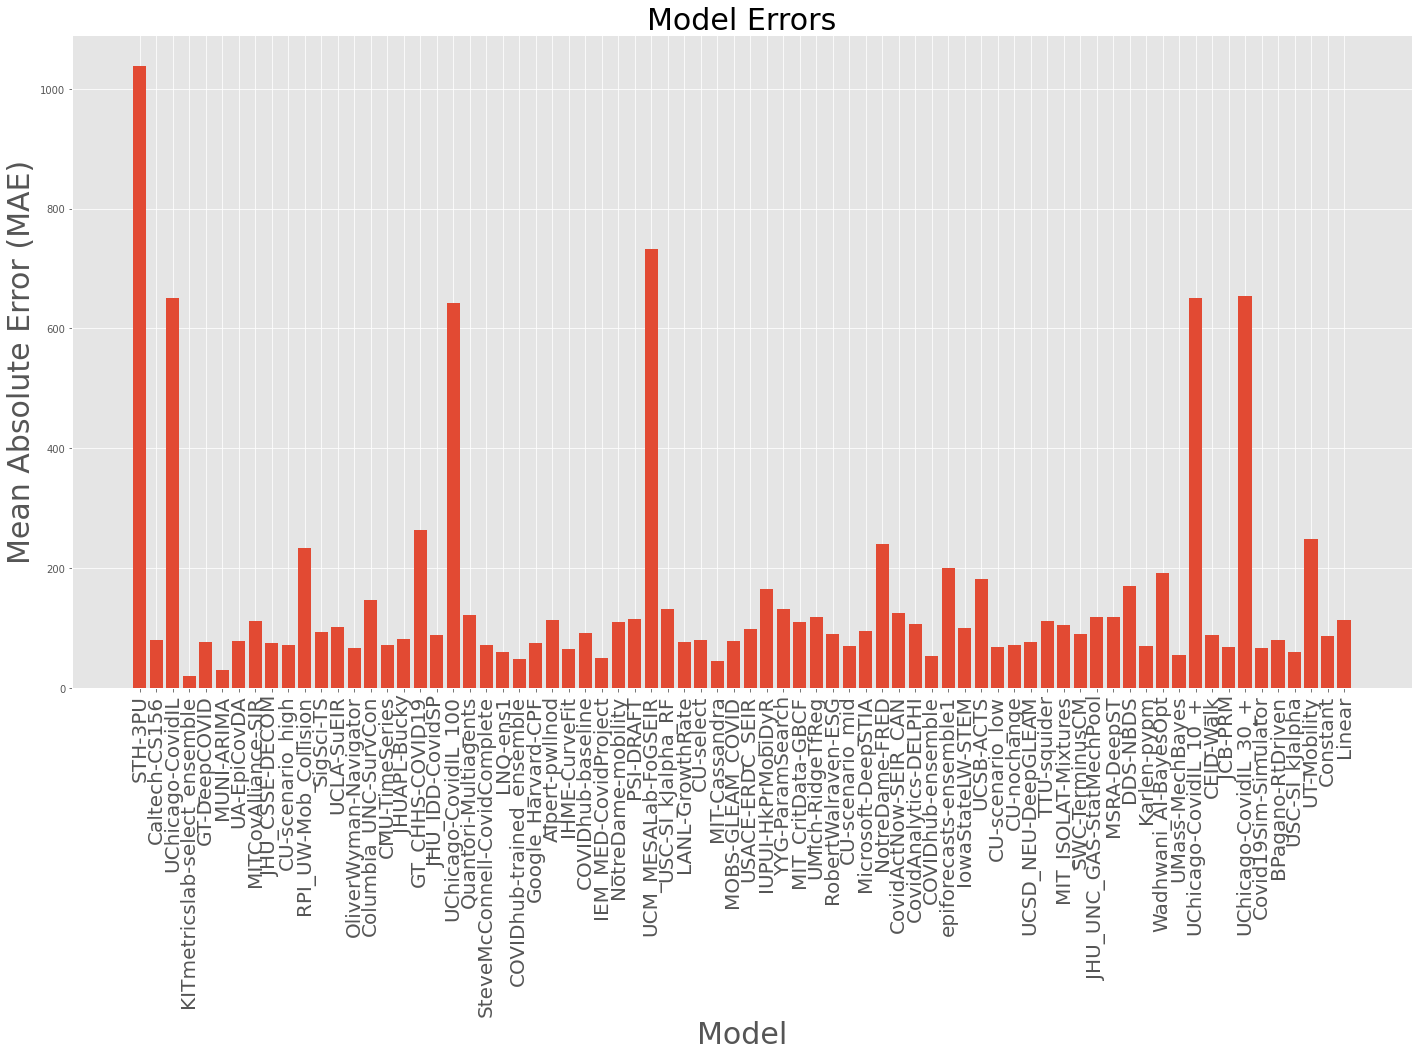

In [7]:
# Here, we compute MAE values for different models.

model_maes = []

for forecast in model_forecasts:
    mae = sum( abs( np.array( forecast['forecast'] ) - np.array( forecast['truth'] ) ) ) / len( forecast )
    model_maes.append( mae )

plot_errors( 'Model Errors', "Mean Absolute Error (MAE)", valid_model_names, model_maes )

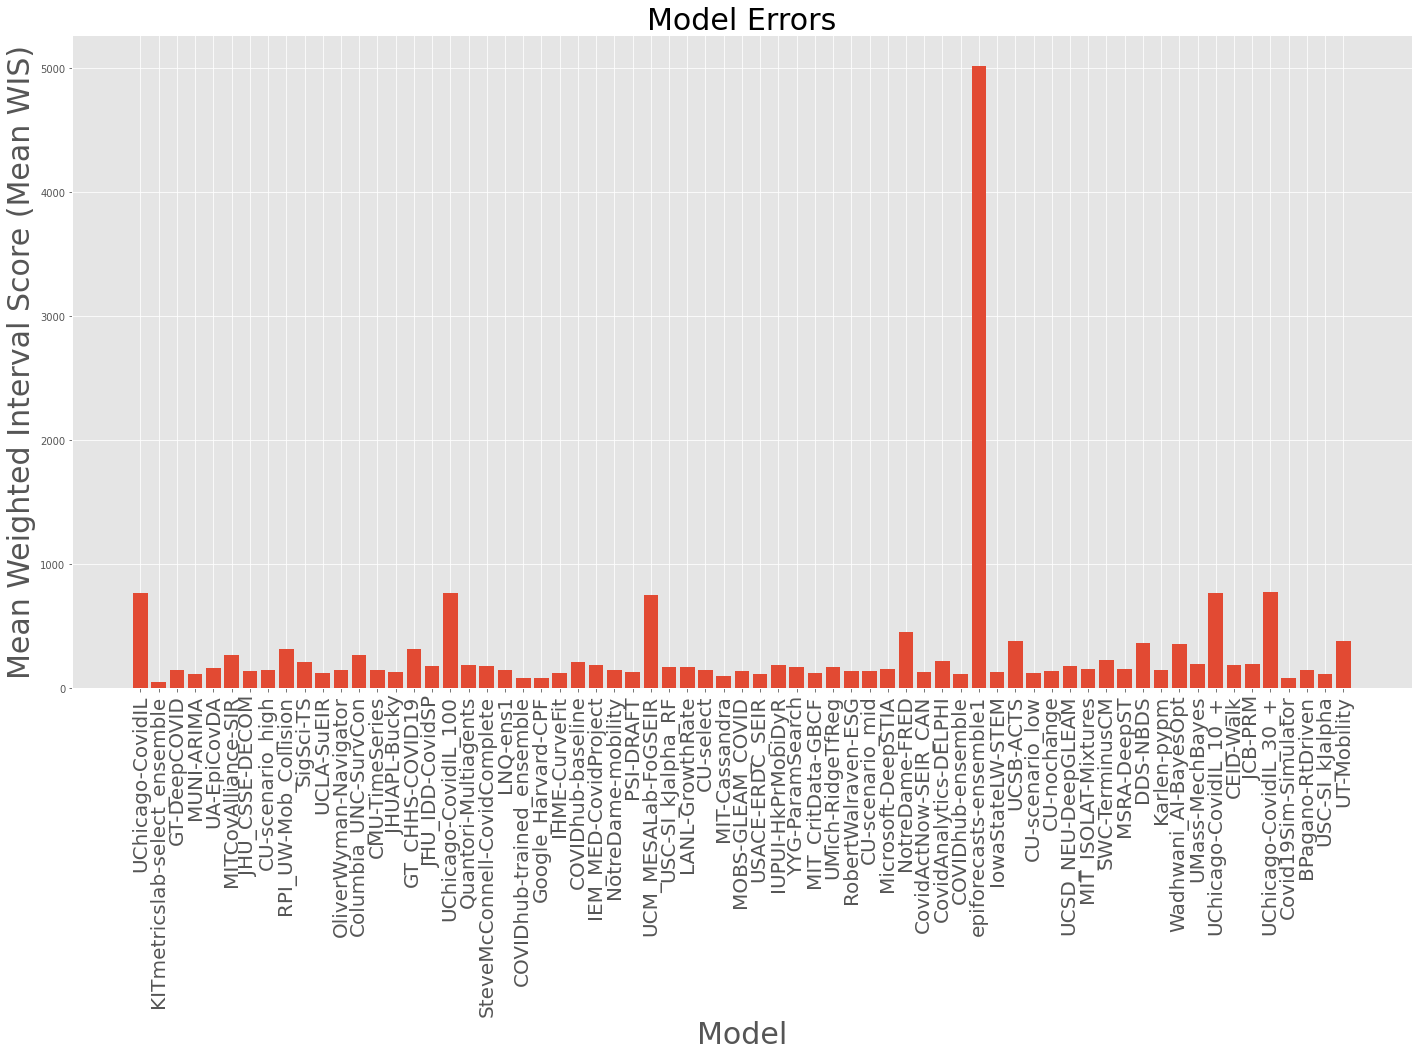

In [8]:
# Here, we compute WIS values for different models.

import weighted_interval_score

def compute_wis( forecast, alphas, suffix = '' ):
    locations = set( forecast['location' + suffix] )
    locations = list( locations )
    locations.sort()
    
    dates = set( forecast['date' + suffix] )
    dates = list( dates )
    dates.sort()
    
    total_wis = 0
    observation_count = 0
    
    for location in locations:
        for date in dates:
            forecast_for_observation = forecast.loc[ ( ( forecast['location' + suffix] == location ) & ( forecast['date' + suffix] == date ) ) ]
            if len( forecast_for_observation ) == 0:
                continue
            
            quantiles = {}
            truth = None
            for index, row in forecast_for_observation.iterrows():
                if truth == None:
                    truth = row['truth' + suffix]
                else:
                    assert truth == row['truth' + suffix]
                
                quantiles[ row['quantile' + suffix] ] = row['forecast' + suffix]
            
            try:
                wis = weighted_interval_score.WIS_alpha( quantiles[0.5], truth, alphas, quantiles )
            except:
                print( forecast_for_observation )
            total_wis += wis
            observation_count += 1
    
    return total_wis / observation_count

alphas = []

for required_quantile in required_quantiles[ : math.floor( len( required_quantiles ) / 2 ) ]:
    alphas.append( required_quantile * 2 )

model_wis = []

for forecast in p_model_forecasts:
    model_wis.append( compute_wis(forecast, alphas) )

plot_errors( 'Model Errors', "Mean Weighted Interval Score (Mean WIS)", p_valid_model_names, model_wis )

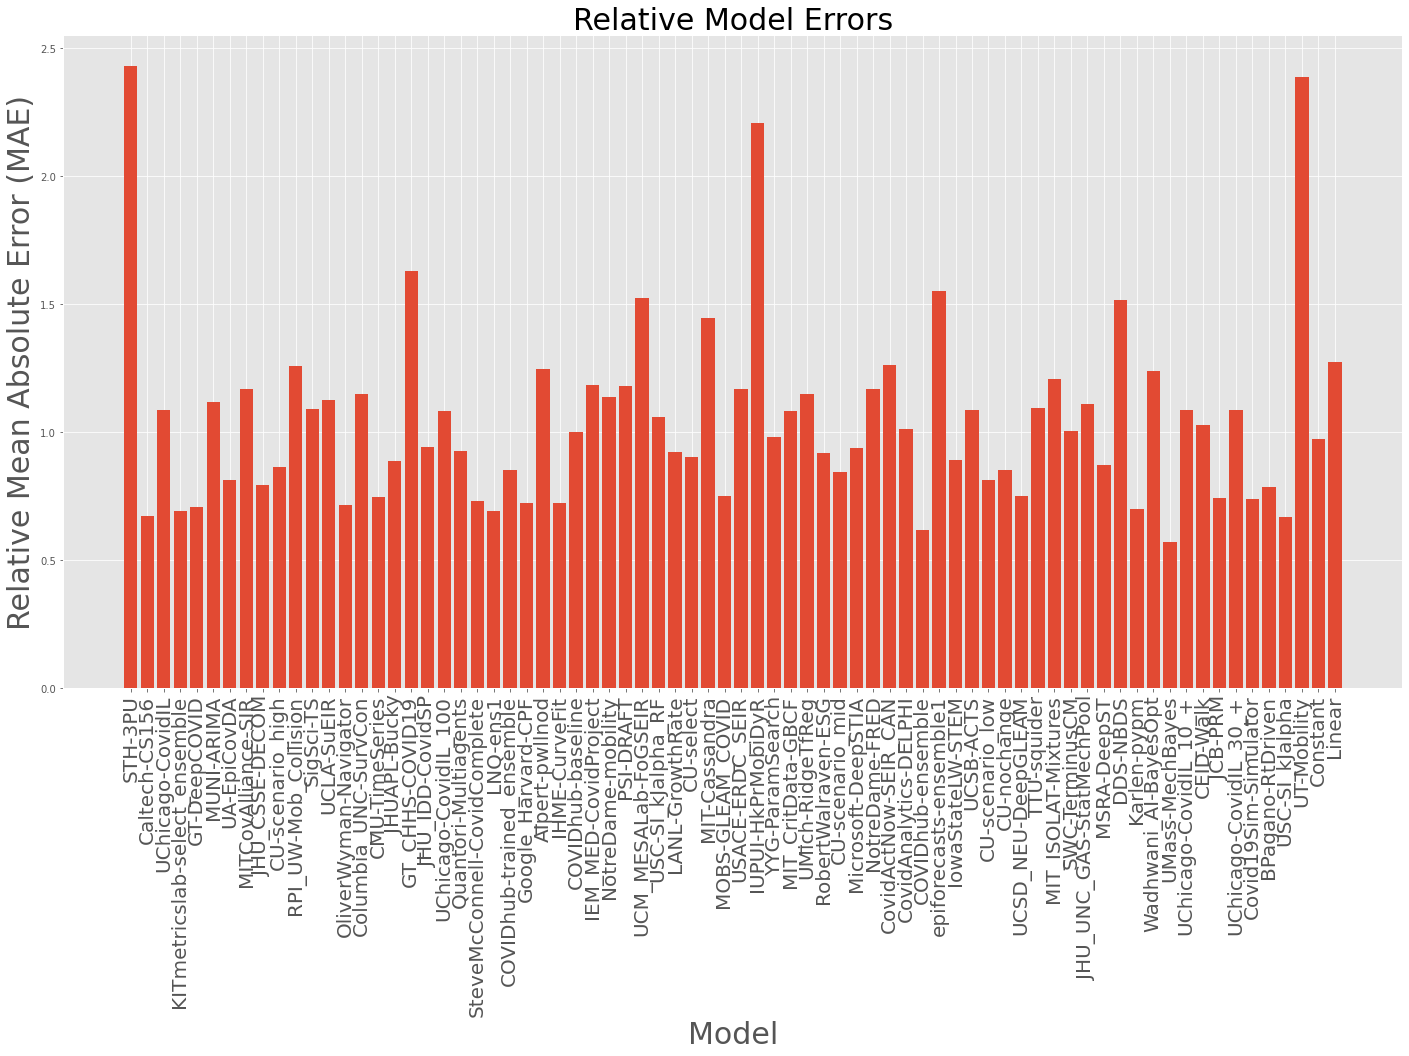

In [9]:
# Here, we compute relative MAE values for different models.
# To instead compute the relative WIS values, replace the line:
# pairwise_relative_mae = sum( abs( np.array( pairwise_forecast['forecast_x'] ) - np.array( pairwise_forecast['truth_x'] ) ) ) / sum( abs( np.array( pairwise_forecast['forecast_y'] ) - np.array( pairwise_forecast['truth_y'] ) ) )
# with:
# pairwise_relative_mae = compute_wis(forecast, alphas, suffix='_x') / compute_wis(forecast, alphas, suffix='_y')
# However, note that relative WIS is much more expensive to compute than relative MAE.

def compute_relative_mae( model_forecasts, model_index, baseline_index ):
    mean_relative_mae = 1
    for j in range( len( model_forecasts) ):
        if j == model_index:
            continue
        
        if j == baseline_index:
            continue
        
        pairwise_forecast = pd.merge( model_forecasts[model_index], model_forecasts[j], on=['date', 'location'], how='inner' )
        if len(pairwise_forecast) == 0:
            continue        
        
        pairwise_relative_mae = sum( abs( np.array( pairwise_forecast['forecast_x'] ) - np.array( pairwise_forecast['truth_x'] ) ) ) / sum( abs( np.array( pairwise_forecast['forecast_y'] ) - np.array( pairwise_forecast['truth_y'] ) ) )
        mean_relative_mae *= pairwise_relative_mae

    mean_relative_mae = mean_relative_mae ** ( 1.0 / len(model_forecasts) ) # Should the power be len(model_forecasts) minus 1 (for the model itself) minus the number of models with no overlapping forecasts?    
    
    return mean_relative_mae

baseline_model_index = valid_model_names.index( 'COVIDhub-baseline' )

baseline_relative_mae = compute_relative_mae( model_forecasts, baseline_model_index, -1 )

# print( baseline_relative_mae )

# relative_maes_1 = []

# for i in range( len( model_forecasts ) ):
#     mean_relative_mae = compute_relative_mae( model_forecasts, i, -1 ) # Here, all models are compared against all models, including the baseline model.
#     # print( mean_relative_mae )
#     relative_maes_1.append( mean_relative_mae / baseline_relative_mae )

# plot_errors( 'Relative Model Errors', valid_model_names, relative_maes_1 )

relative_maes_2 = []

for i in range( len( model_forecasts ) ):
    mean_relative_mae = compute_relative_mae( model_forecasts, i, baseline_model_index ) # Here, all models are compared against all models, except for the baseline model.
    relative_maes_2.append( mean_relative_mae / baseline_relative_mae )

plot_errors( 'Relative Model Errors', "Relative Mean Absolute Error (MAE)", valid_model_names, relative_maes_2 )